In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%run data_pipeline.ipynb

########## Data pipeline ##########

Preparing CMU data
379 movies shared both name and release year, dropping
314 movies had actors with the same name, dropping

Merging Oscar dataset, after merge:
Number of different Oscar nominated movies in dataset: 952 in total 63968 different movies
Number of different Oscar nominated actors in dataset: 801 in total 134907 different actors
Number of Oscar nominated rows: 1443

Merging IMDb dataset, after merge:
Number of movies with ratings: 36758
Oscar nominated movies with rating: 939
Number of rows in data before cleaning:  443504
Number of rows in data after cleaning:  23819
Number of rows where age is < 0: 7 . Dropping these rows

FINAL STATE OF DATA
Number of rows:  23812
Number of different Oscar nominated movies in dataset: 394 in total 5987 different movies
Number of different Oscar nominated actors in dataset: 284 in total 2959 different actors
Number of Oscar nominated rows: 519
Processing done, dataset written to cache/data.csv


In [9]:
import pandas as pd

# Load the data
genres_df = pd.read_parquet('cache/genres.parquet')
languages_df = pd.read_parquet('cache/languages.parquet')
countries_df = pd.read_parquet('cache/countries.parquet')
data_df = pd.read_parquet('cache/data.parquet')
data_df['oscar_nominated'] = data_df['oscar_nominated'].astype(float)

### Find number of movies the actor starred in prior to starring in the current movie

In [13]:
data_df.category.unique()

array([None, 'ACTOR IN A LEADING ROLE', 'ACTOR',
       'ACTOR IN A SUPPORTING ROLE', 'ACTRESS IN A SUPPORTING ROLE',
       'ACTRESS IN A LEADING ROLE', 'ACTRESS'], dtype=object)

### Find distribution of number of movies actors star in

In [5]:
# The cumulative count does not make sense for the earlier movies since we don't count movies
# prior to that. We set the year to 2000 since now this issue would only occur if actors starred in a movie
# prior to 1928 and were nominated for an Oscar after 2000. Which is unlikely.

post_2000_df = data_df.loc[data_df['year'] > 2000]

# Split data into data for actors who have been nominated for an Oscar before and after the nomination.
first_oscar_nomination_year_df = post_2000_df.loc[post_2000_df['oscar_nominated'] == 1].groupby('actor_identifier').agg(
    year_of_first_oscar_nomination=('year', 'min')).reset_index()
temp_df = post_2000_df.merge(first_oscar_nomination_year_df, on='actor_identifier')

pre_first_oscar_nominated_df = temp_df.loc[temp_df['year'] < temp_df['year_of_first_oscar_nomination']]

first_oscar_nomination_df = temp_df.loc[temp_df['year'] == temp_df['year_of_first_oscar_nomination']]

post_first_oscar_nominated_df = temp_df.loc[temp_df['year'] > temp_df['year_of_first_oscar_nomination']]

# Select the last movie for actors who have not been nominated for an Oscar
non_nominated_df = post_2000_df.loc[post_2000_df['oscar_nominated'] == 0]
temp_df = non_nominated_df.groupby('actor_identifier').agg(
    max_number_of_movies_starred_in=('number_of_movies_starred_in', 'max')).reset_index()
non_nominated_df = non_nominated_df.merge(temp_df, on='actor_identifier')
non_nominated_df = non_nominated_df.loc[non_nominated_df['number_of_movies_starred_in'] == non_nominated_df['max_number_of_movies_starred_in']]

# Select the last movie for actors who have been nominated for an Oscar
nominated_df = post_2000_df.loc[post_2000_df['oscar_nominated'] == 1]
temp_df = nominated_df.groupby('actor_identifier').agg(
    max_number_of_movies_starred_in=('number_of_movies_starred_in', 'max')).reset_index()
nominated_df = nominated_df.merge(temp_df, on='actor_identifier')
nominated_df = nominated_df.loc[nominated_df['number_of_movies_starred_in'] == nominated_df['max_number_of_movies_starred_in']]

print("pre first oscar nomination length: ", len(pre_first_oscar_nominated_df))   
print("first oscar nomination length: ", len(first_oscar_nomination_df))
print("post first oscar nomination length: ", len(post_first_oscar_nominated_df))
print("non nominated length: ", len(non_nominated_df))
print("nominated length: ", len(nominated_df))

pre first oscar nomination length:  411
first oscar nomination length:  192
post first oscar nomination length:  797
non nominated length:  2559
nominated length:  106


Text(0.5, 0, 'Number of movies starred in')

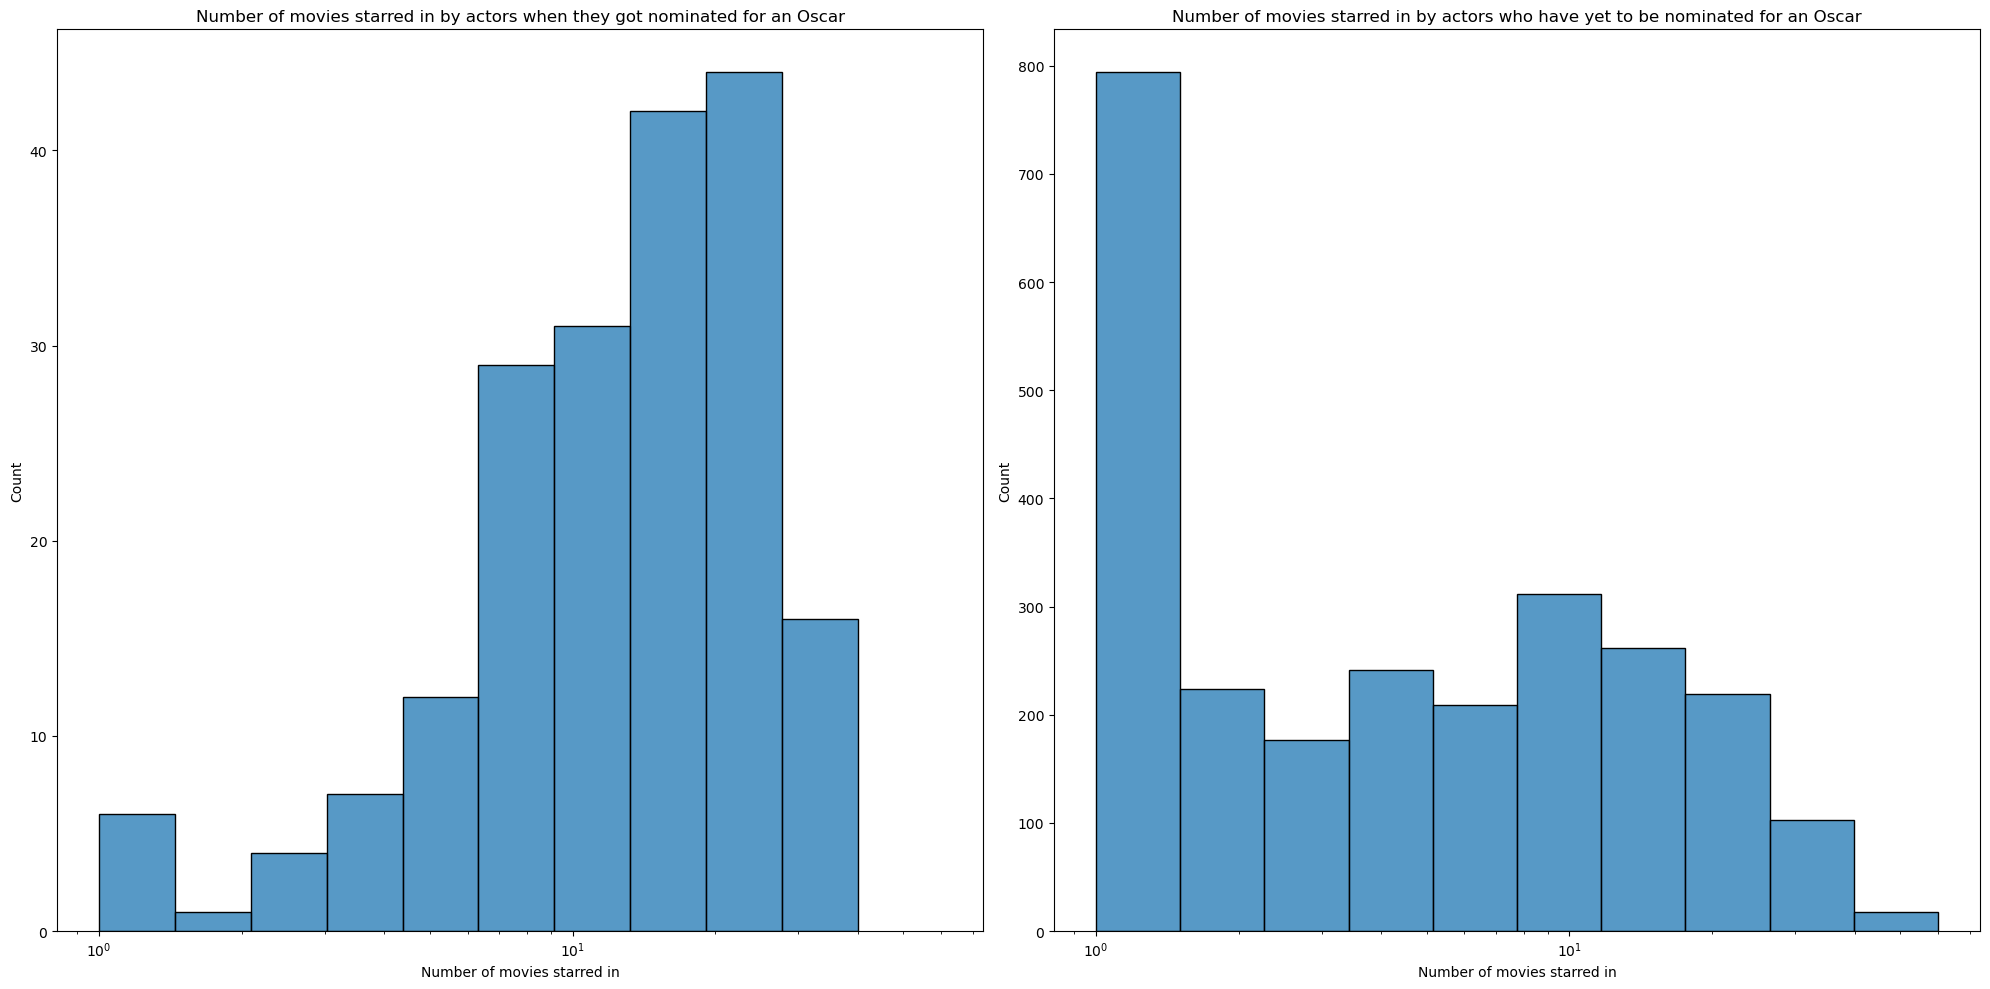

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), layout='tight', sharex=True)
sns.histplot(
    data=first_oscar_nomination_df, 
    x='number_of_movies_starred_in', 
    bins=10, 
    log_scale=True,
    ax=axs[0])

sns.histplot(
    data=non_nominated_df, 
    x='number_of_movies_starred_in', 
    bins=10, 
    
    log_scale=True,
    ax=axs[1])

axs[0].set_title('Number of movies starred in by actors when they got nominated for an Oscar')
axs[1].set_title('Number of movies starred in by actors who have yet to be nominated for an Oscar')

axs[0].set_xlabel('Number of movies starred in')
axs[1].set_xlabel('Number of movies starred in')

In [14]:
print('Mean number of movies starred in before being nominated for an Oscar: ', first_oscar_nomination_df['number_of_movies_starred_in'].mean())
print('Mean number of movies starred in for actors who have not been nominated for an Oscar: ', non_nominated_df['number_of_movies_starred_in'].mean())

Mean number of movies starred in before being nominated for an Oscar:  15.130208333333334
Mean number of movies starred in for actors who have not been nominated for an Oscar:  7.670965220789371


Text(0.5, 0, 'Age in years')

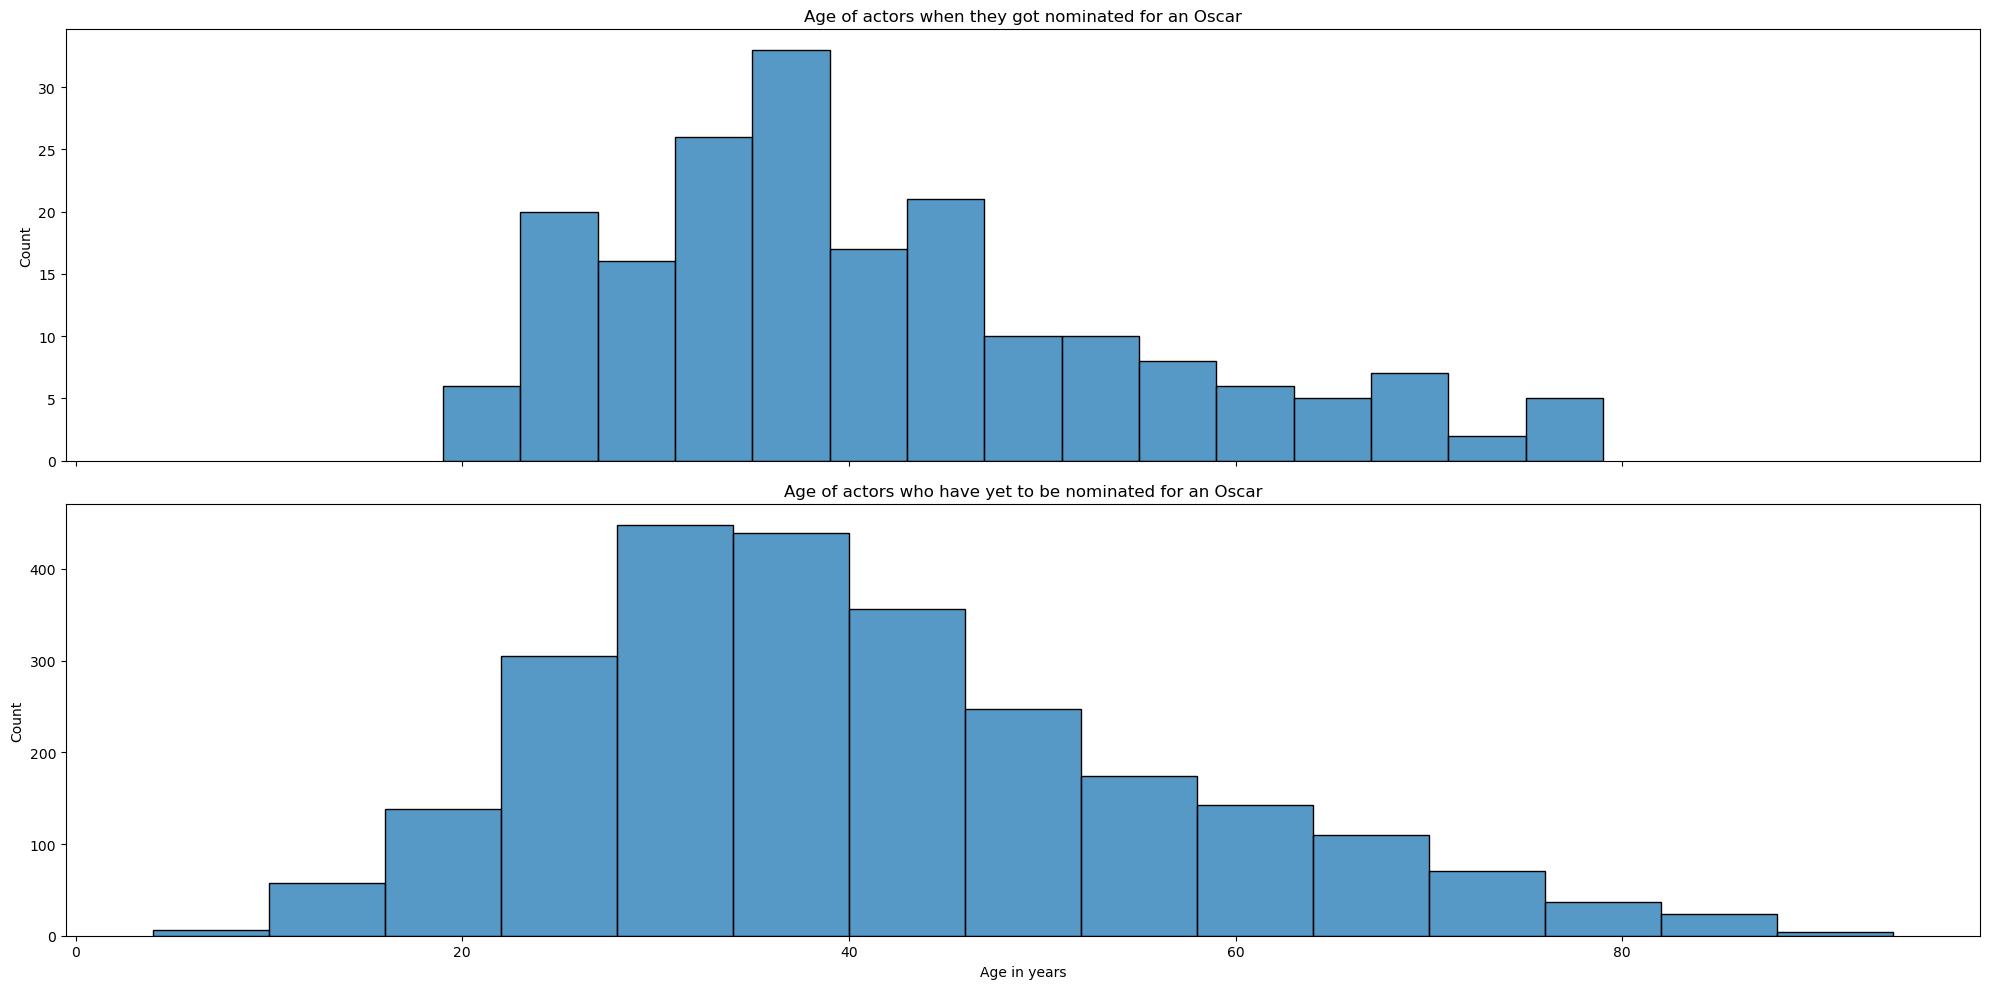

In [15]:

fig, axs = plt.subplots(2, 1, figsize=(20, 10), layout='tight', sharex=True)
sns.histplot(
    data=first_oscar_nomination_df, 
    x='actor_age', 
    bins=15, 
    log_scale=False,
    ax=axs[0])

sns.histplot(
    data=non_nominated_df, 
    x='actor_age', 
    bins=15,
    log_scale=False,
    ax=axs[1])

axs[0].set_title('Age of actors when they got nominated for an Oscar')
axs[1].set_title('Age of actors who have yet to be nominated for an Oscar')

axs[0].set_xlabel('Age in years')
axs[1].set_xlabel('Age in years')


In [16]:
# Lets compare the average age of the groups
print('Mean age of actors when being nominated for an Oscar: ', first_oscar_nomination_df['actor_age'].mean())
print('Mean age of actors who have not been nominated for an Oscar: ', non_nominated_df['actor_age'].mean())

Mean age of actors when being nominated for an Oscar:  41.265625
Mean age of actors who have not been nominated for an Oscar:  40.417741305197346


In [ ]:
# Do a p-test to see if the difference is significant
from scipy.stats import ttest_ind

ttest_number_of_movies_result = ttest_ind(non_nominated_df['number_of_movies_starred_in'], first_oscar_nomination_df['number_of_movies_starred_in'])
print('P-value number of movies starred in:', ttest_number_of_movies_result.pvalue)

In [ ]:
print('Youngest actor to be nominated for an Oscar: ', first_oscar_nomination_df['actor_age'].min())

## Observations
Actors who got nominated for an Oscar in the period 2000-2012 starred on average in 15.13 movies before being nominated, while an actor who have not been nominated yet has on average starred in 7.67. The T-test shows a p-value of 3.8e-30 confirming that the distribution are different between the groups.

Observing the age distributions of the groups we observe that the group of non nominated actors include very young actors while the nominated group only includes actors starting from 19 years of age. This could be the reason for the lower average of movies in the non nominated group. Lets observe the distribution of non nominated actors who are over the age of 19.

In [17]:
non_nominated_df['actor_age'].min()

np.int64(4)

<Axes: xlabel='number_of_movies_starred_in', ylabel='Count'>

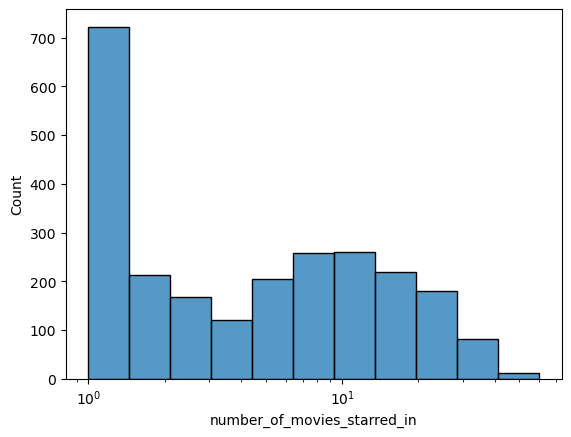

In [18]:
plot_data_df = non_nominated_df.loc[non_nominated_df['actor_age'] >= 19, :]    

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

sns.histplot(
    data=plot_data_df, 
    x='number_of_movies_starred_in', 
    log_scale=True, 
    bins=11,
    ax=axs)

axs.set_title("Distribution of number of movies starred in by actors who have not been nominated for an Oscar and are 19 years old or older")


In [19]:
print('Mean number of movies starred in for actors who have not been nominated for an Oscar and are above 19 years old: ', plot_data_df['number_of_movies_starred_in'].mean())

Mean number of movies starred in for actors who have not been nominated for an Oscar and are above 19 years old:  7.921849427168576


In [ ]:
# Test significance
ttest_number_of_movies_result = ttest_ind(plot_data_df['number_of_movies_starred_in'], first_oscar_nomination_df['number_of_movies_starred_in'])
print('P-value number of movies starred in:', ttest_number_of_movies_result.pvalue)

### Observations

After filtering so that the non-nominated group only includes actors older than 19 we still observe a discrepency in the number of movies actors star in between the two groups. Further we observe this difference to be significent.

Thus the conclusion is that it is seldom that actors get nominated early in their career.

## Further investigation
Observing that Actors need to star in more movies than the average actor to be nominated for an Oscar. This leaves the question if this is due to more "entries" in the lottery or actors become more established. In order to investigate this we assume movie nominations are i.i.d.

In [ ]:
# This analysis does not really make sense.
import math
# Calculate probablity of being nominated for an Oscar
p = first_oscar_nomination_df.loc[first_oscar_nomination_df['number_of_movies_starred_in'] == 1, 'oscar_nominated'].sum() / len(post_2000_df)
print('Probability of being nominated for an Oscar between 2000-2012 starring in 1 movie: ', p)

actual = []
theoretical = []

for i in range(1, 55):
    actual_p = first_oscar_nomination_df.loc[first_oscar_nomination_df['number_of_movies_starred_in'] <= i, 'oscar_nominated'].sum() / len(post_2000_df)
    theoretical.append(i*p) 
    actual.append(actual_p)

plt.plot(range(1, 55), actual, label='Theoretical')   
plt.plot(range(1, 55), theoretical, label='Actual')

# Incitament for being nominated an Oscar
Of course, it is a great achievement to be nominated for an Oscar. But how does in impact the career of an actor. 

In [ ]:
# Find the last movie for an actor before they were nominated for an Oscar
pre_first_oscar_nominated_df['max_number_of_movie_starred_in_before_oscar'] = pre_first_oscar_nominated_df.groupby('actor_identifier')['number_of_movies_starred_in'].transform('max')
last_movie_before_oscar_df = pre_first_oscar_nominated_df.loc[pre_first_oscar_nominated_df['number_of_movies_starred_in'] == pre_first_oscar_nominated_df['max_number_of_movie_starred_in_before_oscar']]

# # Find the last movie for an actor after they were nominated for an Oscar
post_first_oscar_nominated_df['max_number_of_movie_starred_in_after_oscar'] = post_first_oscar_nominated_df.groupby('actor_identifier')['number_of_movies_starred_in'].transform('max')
last_movie_after_oscar_df = post_first_oscar_nominated_df.loc[post_first_oscar_nominated_df['number_of_movies_starred_in'] == post_first_oscar_nominated_df['max_number_of_movie_starred_in_after_oscar']]

fig, axs = plt.subplots(1, 3, figsize=(20, 10), layout='tight')
# sns.scatterplot(data=last_movie_before_oscar_df, x='average_rating_previous_movies', y='average_box_office_revenue_previous_movies', color='blue', ax=axs)
# sns.scatterplot(data=last_movie_after_oscar_df, x='average_rating_previous_movies', y='average_box_office_revenue_previous_movies', color='green', ax=axs)
# sns.scatterplot(data=first_oscar_nomination_df, x='average_rating', y='box_office_revenue', color='red', ax=axs)
sns.histplot(data=last_movie_before_oscar_df, x='average_box_office_revenue_previous_movies', bins=10, color='blue', ax=axs[0])
sns.histplot(data=last_movie_after_oscar_df, x='average_box_office_revenue_previous_movies', bins=10, color='green', ax=axs[1])
sns.histplot(data=non_nominated_df, x='average_box_office_revenue_previous_movies', bins=10, color='red', ax=axs[2])
# sns.histplot(data=first_oscar_nomination_df, x='average_rating', bins=10, color='red', ax=axs)
axs[0].set_title('Average box office revenue of movies before oscar nomination')
axs[1].set_title('Average box office revenue of movies after oscar nomination')
axs[2].set_title('Average box office revenue of movies for actors who have not been nominated for an Oscar')


In [ ]:
# Comparing the average box office revenue of the groups and testing for significance
print('Mean average box office revenue of movies before oscar nomination: ', last_movie_before_oscar_df['average_box_office_revenue_previous_movies'].mean())
print('Mean average box office revenue of movies after oscar nomination: ', last_movie_after_oscar_df['average_box_office_revenue_previous_movies'].mean())
print('Mean average box office revenue of movies for actors who have not been nominated for an Oscar: ', non_nominated_df['average_box_office_revenue_previous_movies'].mean())

ttest_box_office_revenue_result = ttest_ind(last_movie_before_oscar_df['average_box_office_revenue_previous_movies'], last_movie_after_oscar_df['average_box_office_revenue_previous_movies'])
print('P-value average box office revenue before vs after oscar nomination:', ttest_box_office_revenue_result.pvalue)

ttest_box_office_revenue_result = ttest_ind(last_movie_after_oscar_df['average_box_office_revenue_previous_movies'], non_nominated_df['average_box_office_revenue_previous_movies'])
print('P-value average box office revenue after oscar nomination vs not nominated:', ttest_box_office_revenue_result.pvalue)

ttest_box_office_revenue_result = ttest_ind(last_movie_before_oscar_df['average_box_office_revenue_previous_movies'], non_nominated_df['average_box_office_revenue_previous_movies'])
print('P-value average box office revenue before oscar nomination vs not nominated:', ttest_box_office_revenue_result.pvalue)

# Observing the p-values we can not conclude that being nominated for an Oscar has a significant effect on the average box office revenue of the movies.
# Both compared to before and after the nomination. But also compared to actors who have not been nominated for an Oscar.